# Graph Data

#### **Imports**

In [53]:
# Standard library imports
import warnings
from collections import Counter
import statistics

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from sklearn import metrics as ms
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid

# Node2Vec imports
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder

# Custom module imports
from edge_split import EdgeSplitter

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="networkx")

#### **Random Seed**

In [54]:
# Set the random seed for reproducibility
random_seed = 42

# Task 1 – Story

I work as a data scientist for BlueNote Records, a prestigious jazz music label known for its iconic albums and artists. Our label aims to promote talent and support unique collaborations that push the boundaries of jazz music. By using data science, BlueNote Records intends to gain insights into the jazz musicians network and identify new and promising collaborations between jazz musicians.

##### **Project and Task:**
The project focuses on analyzing the Jazz musicians collaboration network to predict future collaborations. This analysis aims to provide BlueNote Records with a deeper understanding of the network dynamics, enabling the label to suggest potential collaboration opportunities to artists and producers. By doing so, BlueNote Records can accelerate the creation of innovative music and maintain its reputation as a pioneer in the jazz industry.

##### **Plan of the Experiment:**

- ***Initial Data Analysis (IDA)***: Conduct a preliminary analysis of the Jazz musicians network to understand its overall structure and key characteristics.
- ***Graph Properties:*** Compute and explore various graph properties to gain deeper insights into the network's dynamics.
- ***Central Nodes:*** Identify the most influential musicians using different centrality measures to determine key players in the network.
- **Prediction Task:** Set up a link prediction experiment using Node2Vec embeddings and machine learning algorithms to forecast new collaborations.

##### **Purpose and Value:**
The expected outcome is to accurately predict potential collaborations, which will:

- ***Enable Strategic Collaborations:*** Suggest new and promising collaboration opportunities to artists and producers.
- ***Enhance the Label's Portfolio:*** Enrich the label’s music library with innovative and diverse collaborations.
- ***Maintain Industry Leadership:*** Ensure BlueNote Records remains at the top of the jazz music industry by continually driving innovation and creativity.

By successfully predicting new collaborations, BlueNote Records can strategically bring musicians together, fostering innovative projects that fascinate the jazz audience. This proactive approach not only enhances the label’s reputation but also supports the artistic growth of the musicians.

# Task 2 – The Data

##### **Dataset Description:**

The dataset is a collaboration network between Jazz musicians. Each node represents a Jazz musician, and an edge denotes that two musicians have played together in a band. The data was collected in 2003.

##### **Metadata:**

- ***Name:*** Jazz musicians
- ***Category:*** Human social network
- ***Dataset Timestamp:*** 2003
- ***Node Meaning:*** Represent individual Jazz musicians.
- ***Edge Meaning:*** Represent collaborations where two musicians have played together in a band.
- ***Network Format:*** Unipartite and undirected.
- ***Edge Type:*** Unweighted, no multiple edges.
- ***Loops:*** Does not contain loops.
- ***Snapshot:*** Is a snapshot and likely to not contain all data.
- ***Join:*** Is the join of an underlying network.

##### **Sources:**

- ***Download Source:*** The download source where I obtained the dataset is http://konect.cc/networks/arenas-jazz/. (Accessed on 04.05.2024)
- ***Original Source:*** The original source of the dataset is https://webs-deim.urv.cat/~alexandre.arenas/data/welcome.htm, and they request to cite the following reference: P.Gleiser and L. Danon, Adv. Complex Syst.6, 565 (2003).

##### **Suitability for the Project:**

This dataset is ideal for the project as it directly relates to predicting future collaborations. The unipartite, undirected nature of the network, with unweighted edges, simplifies analysis while still providing rich information about the relationships between musicians. The lack of loops and multiple edges ensures a clean dataset for applying graph algorithms.
Since the data only contains integers for the musicians, we assume that BlueNote Records has access to additional information so that the integers can be mapped to the actual musicians.

In [55]:
# Load the Jazz network
G = nx.read_edgelist('data/jazz.net', comments='*', nodetype=int, data=False)

# Task 3 – IDA

#### **Basic Properties**
In the following, basic properties of the Jazz musician collaboration network are analyzed.

In [56]:
# Print if the graph is directed
if nx.is_directed(G):
    print("The graph is directed.")
else:
    print("The graph is undirected.")

# Check if the graph is weighted
if nx.is_weighted(G):
    print("The graph is weighted.")
else:
    print("The graph is unweighted.")

The graph is undirected.
The graph is unweighted.


The Jazz musician graph is **undirected** and **unweighted**, which is consistent with the dataset description, provided by the source. 

In [57]:
# Print if undirected graph is connected
if nx.is_connected(G):
    print("The graph is connected.")
else:          
    print("The graph is not connected.")

The graph is connected.


The network is **connected**, meaning that it contains no Jazz musician without any collaborations.

In [58]:
# Print the number of nodes and edges in the graph
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print("Number of nodes (Jazz musicians):", n_nodes)
print("Number of edges (Collaborations):", n_edges)

Number of nodes (Jazz musicians): 198
Number of edges (Collaborations): 2742


The Graph contains **198 Jazz musicians** and **2742 collaborations**, between them.

In [59]:
# Print the average degree of the graph
print("Average degree:", round(sum(dict(G.degree()).values()) / G.number_of_nodes(), 2))

Average degree: 27.7


On average, each musician has **collaborated** with approximately 28 other musicians.

In [60]:
# Print the density of the graph
density = round(nx.density(G), 2)
print("Density:", density)

Density: 0.14


The **density** of the graph is 0.14, which means that approximately 14% of all possible collaborations between musicians are present in the graph. That means there is still plenty of room for new collaborations, that can be predicted.

In [61]:
# Print the average clustering coefficient of the graph
avg_clustering = round(nx.average_clustering(G), 2)
print("Average clustering coefficient:", avg_clustering)

Average clustering coefficient: 0.62


The **average cluster coefficent** of 0.62 suggests that there is a relatively high tendency for musicians to form collaborative clusters or groups.

In [62]:
# Print the diameter of the graph (if the graph is connected)
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print("Diameter:", diameter)

Diameter: 6


The **diameter** of 6 indicates that any musician can be reached from any other musician in a maximum of 6 steps along the collaborations.

In [63]:
# Print the average shortest path length of the graph (if the graph is connected)
if nx.is_connected(G):
    avg_shortest_path = round(nx.average_shortest_path_length(G), 2)
    print("Average shortest path length:", avg_shortest_path)

Average shortest path length: 2.24


On average, the **shortest path** between any two musicians in the graph is approximately 2.24 steps. This indicates a small-world property, where jazz musicians are closely connected to each other.

In [64]:
# Print number of triangles
print("Number of triangles:", sum(nx.triangles(G).values()) // 3)

Number of triangles: 17899


The graph contains 17899 **triangles**. A triangle represents three musicians who have all collaborated with each other, this indicates a strong presence of closely connected, collaborative groups. This is probably due to the nature that musicians often play in bands with three or more members.

In [65]:
# Print the assortativity (correlation of the degrees of connected nodes)
assortativity = round(nx.degree_assortativity_coefficient(G), 3)
print("Assortativity:", assortativity)

Assortativity: 0.02


An **assortativity** of 0.02 suggests that there is very little correlation between the degrees of connected nodes. In other words, high-degree musicians are just as likely to collaborate with low-degree musicians as they are with other high-degree musicians.

In [66]:
# Print the transitivity of the graph or global clustering coefficient
transitivity = round(nx.transitivity(G), 3)
print("Transitivity:", transitivity)

Transitivity: 0.52


The **Transitivity** of 0.52 indicates that there is a moderate to high likelihood that the collaborators of a musician also collaborate with each other. 

#### **Plot the Graph**

Since the graph contains only 198 Nodes and 2742 Edges, it is feasible to plot the entire graph. 
The function "plot_graph()" plots the Jazz musician collaboration network using the spring layout algorithm and set the node size in proportion to the degree.

In [67]:
def plot_gaph(G):
    ''' 
    Plot the graph with the spring layout, and the node sizes proportional to the degrees.
    Args:
        G: NetworkX graph object
    Returns:
        None
    '''
    pos = nx.spring_layout(G, seed=random_seed) # Use spring layout 
    degrees = dict(G.degree()) # Get the degrees of the nodes
    node_sizes = [v * 4 for v in degrees.values()] # Node sizes proportional to the degrees
    plt.figure(figsize=(12, 12))
    # edgcolor = black
    nx.draw(G, pos, node_size=node_sizes, with_labels=False, node_color='Red', edge_color='gray', alpha=0.65)

    plt.title("Jazz Musicians Network")
    plt.show()

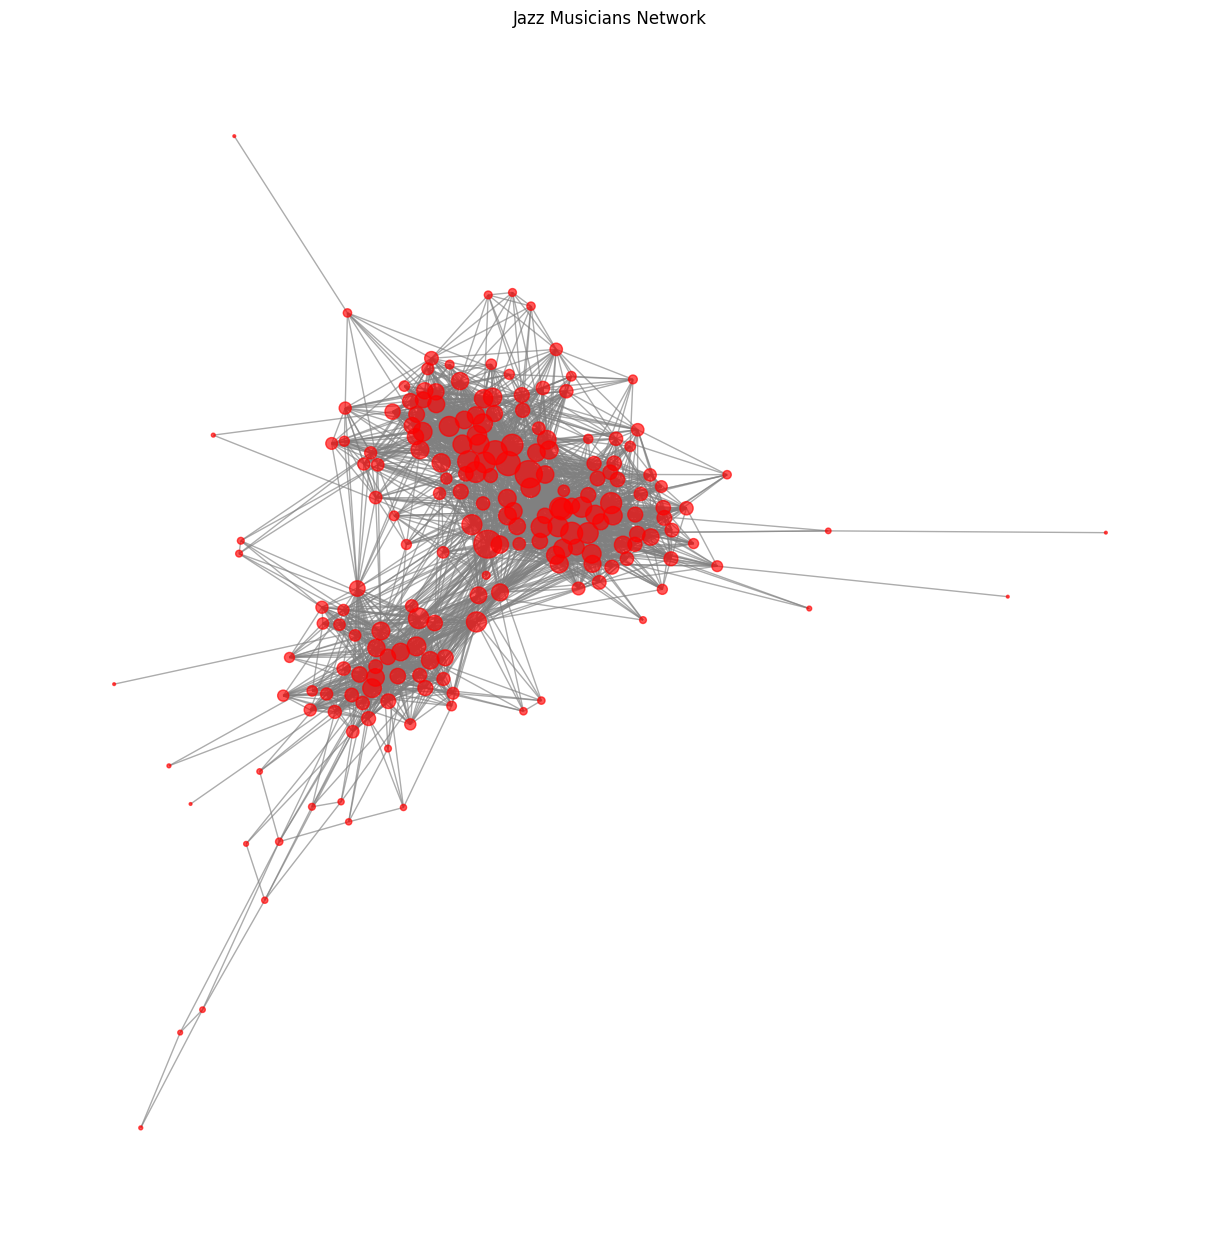

In [68]:
# Plot the graph
plot_gaph(G)

The visualization of the Jazz musicians collaboration network suggests the presence of two prominent clusters of musicians, each densely interconnected, indicating strong internal collaboration within these groups. It looks like there are several connections between the two main clusters, suggesting some level of cross-cluster collaboration, though less frequent compared to within-cluster interactions. Additionally, it appears that there are musicians with fewer connections visible on the outskirts, indicating musicians with only a few collaborations.

# Task 4 – Graph Properties

### **Explore the graph properties**

In the following, graph properties will be calculated and compared to the properties of artificially generated graphs, that have the same number of nodes and edges.

In [69]:
# Empty dataframe for properties comparison
df_properties = pd.DataFrame(columns=['Order', 'Size', 'Density', 'Diameter', 
                                      'Avg. shortest path length', 'Transitivity', 
                                      'Avg. clustering coefficient', 
                                      'Assortativity'])                                  

In [70]:
# Function that calculates and adds properties to the dataframe
def graph_properties(G, name):
    """
    This function takes a graph G as input and adds properties to a dataframe.
    Args: 
        G: Networkx graph
        name: Name of the graph
    Returns:
        None
    """
    # Add the order of the graph to the dataframe
    df_properties.loc[name, 'Order'] = n_nodes

    # Add the size of the graph to the dataframe
    df_properties.loc[name, 'Size'] = n_edges

    # Add the density of the graph to the dataframe
    df_properties.loc[name, 'Density'] = density

    # Add the diameter of the graph to the dataframe
    df_properties.loc[name, 'Diameter'] = diameter

    # Add the average shortest path length of the graph to the dataframe
    df_properties.loc[name, 'Avg. shortest path length'] = avg_shortest_path

    # Add the transitivity of the graph to the dataframe
    df_properties.loc[name, 'Transitivity'] = transitivity

    # Add the average local clustering coefficient of the graph to the dataframe
    df_properties.loc[name, 'Avg. clustering coefficient'] = avg_clustering

    # Add the assortativity of the graph to the dataframe
    df_properties.loc[name, 'Assortativity'] =  assortativity

In [71]:
# Calculate the properties for the Jazz network
graph_properties(G, 'Jazz Musicians Network')

In [72]:
# Create a random graph with same order and size as Jazz Musicians Collaboration Network
density_list = []
diameter_list = []
average_shortest_path_length_list = []
transitivity_list = []
average_local_clustering_coefficient_list = []
assortativity_list = []
size_list = []
order_list = []
connected_list = []

# Set the number of random graphs
n_random_graphs = 50

# Create random graphs and calculate the properties
for i in range(n_random_graphs):

    # Erdős-Rényi-Random Graphs
    # Create a connected random graph with the same order and size as Jazz Musicians Network
    G_random = nx.gnm_random_graph(n = n_nodes, m = n_edges, seed=i)
    
    # Calculate the properties of the random graph
    diameter_list.append(nx.diameter(G_random)) # Calculate the diameter of the graph
    average_shortest_path_length_list.append(nx.average_shortest_path_length(G_random)) # Calculate the average shortest path length of the graph
    density_list.append(nx.density(G_random)) # Calculate the density of the graph
    size_list.append(G_random.number_of_edges()) # Calculate the size of the graph
    order_list.append(G_random.number_of_nodes()) # Calculate the order of the graph
    connected_list.append(nx.is_connected(G_random)) # Check if the graph is connected
    transitivity_list.append(nx.transitivity(G_random)) # Calculate the transitivity of the graph
    average_local_clustering_coefficient_list.append(nx.average_clustering(G_random)) # Calculate the average local clustering coefficient of the graph
    assortativity_list.append(nx.degree_assortativity_coefficient(G_random)) # Calculate the assortativity of the graph
        

# Calculate the average properties and add them to the dataframe
approach = 'Erdős-Rényi-Random Graphs'
df_properties.loc[approach, 'Density'] = round(statistics.mean(density_list),2) # Add the average density
df_properties.loc[approach, 'Diameter'] = round(statistics.mean(diameter_list),2) # Add the average diameter
df_properties.loc[approach, 'Order'] = round(statistics.mean(order_list),2) # Add the average order
df_properties.loc[approach, 'Size'] = round(statistics.mean(size_list),2) # Add the average size
df_properties.loc[approach, 'Transitivity'] = round(statistics.mean(transitivity_list),2) # Add the average transitivity
df_properties.loc[approach, 'Avg. clustering coefficient'] = round(statistics.mean(average_local_clustering_coefficient_list),2) # Add the average local clustering coefficient
df_properties.loc[approach, 'Assortativity'] = round(statistics.mean(assortativity_list),2) # Add the average assortativity
df_properties.loc[approach, 'Avg. shortest path length'] = round(statistics.mean(average_shortest_path_length_list),2) # Add the average shortest path length

In [73]:
# Show the properties of the Jazz Musicians Collaboration Network and the Erdős-Rényi-Random Graphs
df_properties

,Order,Size,Density,Diameter,Avg. shortest path length,Transitivity,Avg. clustering coefficient,Assortativity
Jazz Musicians Network,198,2742,0.14,6,2.24,0.52,0.62,0.02
Erdős-Rényi-Random Graphs,198,2742,0.14,3,1.88,0.14,0.14,-0.01


#### **Comparison:**

- The Order, size, and density are the same for both the Jazz musician graph and the average of the Erdos-Renyi graphs, because they where set to be the same. They are only shown for checking if everything was set correctly.

- A **larger diameter** in the Jazz network implies that the longest shortest path between any two nodes is longer, indicating a more stretched or less uniformly connected structure compared to the random graphs.

- The **slightly longer average shortest path** in the Jazz network suggests that, on average, it takes more steps to cross the network, indicating a slightly less efficiently connected network compared to the random graphs.

- Transitivity (0.52) and average local clustering coefficient (0.62) are significantly higher in the Jazz network compared to the random graphs (both 0.14). **High transitivity and clustering coefficient** in the Jazz network indicate a strong presence of tightly knit communities or groups of musicians who collaborate with each other. In contrast, the random graphs show minimal clustering, suggesting a more evenly distributed connection pattern without strong community structures.

- The **assortativity** of the Jazz network and the random graphs are both **close to zero**, indicating that there is no significant correlation between the degrees of connected nodes in either network. This suggests that high-degree musicians are not more likely to collaborate with other high-degree musicians compared to low-degree musicians.

#### **Degree distribution and Complementary Cumulative relative frequency**

In the following, the degree distribution of the Jazz musician collaboration network is analyzed.

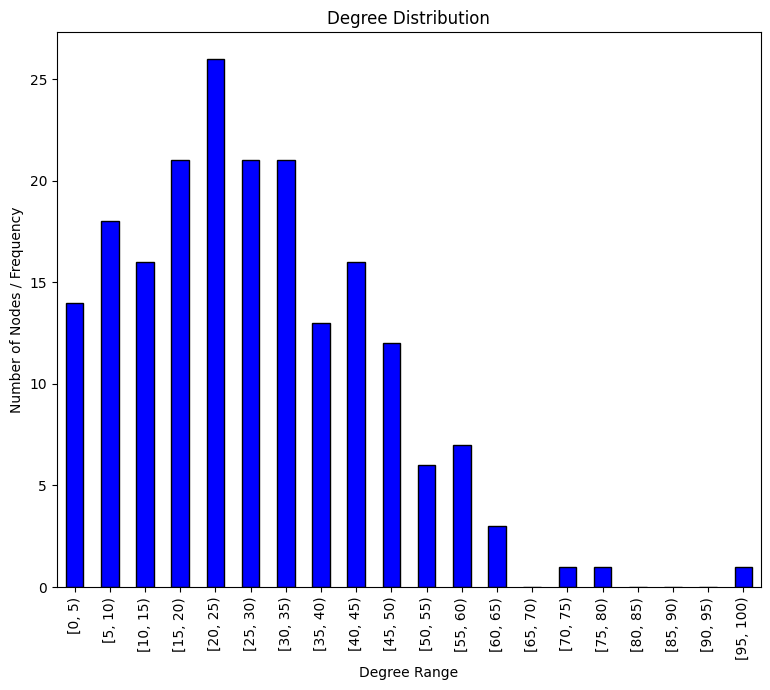

In [74]:
def degree_distribution(G):
    '''
    This function plots the degree distribution 
    Args: 
        G: a networkx graph
    Returns: 
        None
    '''

    # Calculate the degree of each node
    degrees = [degree for _ , degree in G.degree()]

    # Bin the degrees into ranges of length 5
    bins = range(0, max(degrees) + 5, 5)
    degree_bins = pd.cut(degrees, bins=bins, right=False) # Exclude the right 
    degree_distribution = degree_bins.value_counts().sort_index()

    # Plot the degree distribution
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    degree_distribution.plot(kind='bar', color='blue', edgecolor='black')
    plt.xlabel('Degree Range')
    plt.ylabel('Number of Nodes / Frequency')
    plt.title('Degree Distribution')
    plt.tight_layout() # Adjust the layout
    plt.show()

# Plot the degree distribution
degree_distribution(G)

The **degree distribution** of the Jazz musicians collaboration network reveals that most musicians have a small to moderate number of collaborations, with only a few having very high numbers of collaborations (right-skewed). The distribution highlights the presence of key collaborators.

### **Friendship Paradox**

The degree distribution plot above already showed a right-skewed distribution, by looking at the Friendship Paradox a deeper understanding of the unequal distribution of collaborations can be gained.

In [75]:
# Calculate the average degree of each node's neighbors
average_neighbor_degree = nx.average_neighbor_degree(G)

# Count the number of nodes for which the friendship paradox holds true
friendship_paradox_count = sum(G.degree(node) < average_degree for node, average_degree in average_neighbor_degree.items())

# Count the number of nodes for which the friendship paradox holds true
print(f"The friendship paradox holds true for {friendship_paradox_count} of {G.number_of_nodes()} nodes, that are {round(friendship_paradox_count/G.number_of_nodes()*100,2)} % of the nodes.")

The friendship paradox holds true for 150 of 198 nodes, that are 75.76 % of the nodes.


That the friendship paradox holds ture for 76% of the nodes indicates a significant inequality in the distribution of collaborations among musicians and underlines the findings from the degree distribution plot before.

In [76]:
# Calculate the friendship paradox metrics
def friendship_paradox(G):
    '''
    Function to calculate the friendship paradox metrics
    Args:
        G: NetworkX graph
    Returns:
        avg_degree: Average degree of the graph
        avg_neighbors_degree: Average degree of the neighbors
    '''
    degrees = dict(G.degree())
    avg_degree = sum(degrees.values()) / len(degrees)

    neighbors_degrees = []
    for node in G.nodes():
        neighbors_degree_sum = sum(degrees[neighbor] for neighbor in G.neighbors(node))
        if len(list(G.neighbors(node))) > 0:
            neighbors_degrees.append(neighbors_degree_sum / len(list(G.neighbors(node))))

    avg_neighbors_degree = sum(neighbors_degrees) / len(neighbors_degrees)
    
    return avg_degree, avg_neighbors_degree

In [77]:
# Calculate the friendship paradox metrics
avg_degree, avg_neighbors_degree = friendship_paradox(G)

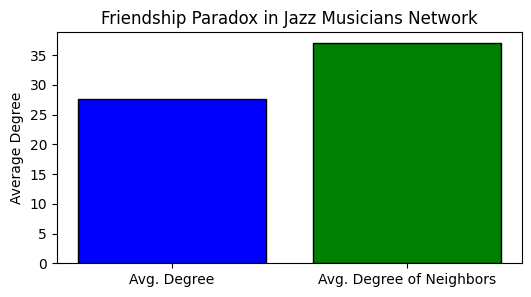

In [78]:
# Visualizing the friendship paradox
labels = ['Avg. Degree', 'Avg. Degree of Neighbors']
values = [avg_degree, avg_neighbors_degree]
plt.figure(figsize=(6, 3))
plt.bar(labels, values, color=['blue', 'green'], edgecolor='black')
plt.title("Friendship Paradox in Jazz Musicians Network")
plt.ylabel("Average Degree")
plt.show()

The average degree of a node is 27, while the average degree of the neighbors of the node is 37, indicating that most musicians have fewer collaborations than their collaborators. This underlines the **inequality in the distribution** of collaborations and indicating the presence of highly influential and well-connected musicians. To indentify these key players, centrality measures will be calculated in the next step.

# Task 5 – Central Nodes

#### **Compute Centrality Measures**
In the following, different centrality measures are calculated to get a better understanding of the relevance/importance/position/role of musicians in the Network.

In [79]:
# Calculate degree centrality
node_degree = nx.degree(G)

# Store the degree centrality in a dictionary
degree_centrality = dict(node_degree)

# Calculate betweenness centrality (indicating bridge nodes)
betweenness = nx.betweenness_centrality(G) 

# Calculate closeness centrality (indicating how close a node is to all other nodes)
closeness = nx.closeness_centrality(G) 

# Create a DataFrame from the dictionaries
df_metrics = pd.DataFrame({
    'Degree centrality': pd.Series(degree_centrality),
    'Betweenness': pd.Series(betweenness),
    'Closeness': pd.Series(closeness)
})

# Calculate ranks for each feature
df_metrics['Degree Rank'] = df_metrics['Degree centrality'].rank(ascending=False, method='min')
df_metrics['Betweenness Rank'] = df_metrics['Betweenness'].rank(ascending=False, method='min')
df_metrics['Closeness Rank'] = df_metrics['Closeness'].rank(ascending=False, method='min')

# Investigate the 15 strongest nodes
df_metrics.sort_values('Degree Rank', ascending=True).head(15)

,Degree centrality,Betweenness,Closeness,Degree Rank,Betweenness Rank,Closeness Rank
136,100,0.151056,0.648026,1.0,1.0,1.0
60,96,0.057539,0.589820,2.0,3.0,2.0
132,75,0.017638,0.554930,3.0,16.0,6.0
168,74,0.039600,0.581121,4.0,5.0,3.0
70,62,0.025732,0.559659,5.0,12.0,4.0
99,60,0.014079,0.536785,6.0,21.0,11.0
108,60,0.009455,0.532432,6.0,37.0,13.0
83,59,0.027580,0.558074,8.0,10.0,5.0
158,59,0.012984,0.538251,8.0,26.0,10.0
7,57,0.009055,0.528150,10.0,41.0,17.0


#### **Findings:**

- **Musicians 136 and 60** are the most connected musicians in the Jazz network, showing the highest degree centrality. Their high betweenness centrality indicates that they play a significant role in connecting different parts of the network, acting as bridges between various groups of musicians. Additionally, their high closeness centrality suggests they can quickly reach other musicians, making them well-connected within the Jazz community.

- **Musician 132** has high degree and closeness centrality but lower betweenness centrality. This suggests that while this musician is well-connected to other musicians and can reach them quickly, he or she does not play a significant role in connecting different communities within the Jazz network. A similar pattern is observed for **musician 70**.

- **Musician 149** shows lower degree and closeness centrality but high betweenness centrality. This indicates that although this musician may not have many collaborations, he or she plays a crucial role in connecting different communities within the Jazz network, serving as an important link between otherwise disconnected groups of musicians.


#### **Community-Based Roles**
Investigating the community-based roles of musicians to get a better understanding relevance/importance/position/role in the network.

In [80]:
# Function to calculate the rawComm score of each node
def raw_comm(G, p, q):
    ''' 
    Function to calculate the rawComm score of each node in a graph
    Args:
        G: A graph object
        p, q: parameters for the rawComm calculation
    Returns:
        rawComm: A dictionary where the key is the node and the value is the rawComm score
    '''
    rawComm = {}
    for u in G.nodes(): # For each node in the graph
        # For all neighbors of u 
        raw_comm = 0
        for v in G.neighbors(u):
            # Calculate the rawComm score
            t_u = 1 / (1 + p * (len(set(G.neighbors(u)).intersection(G.neighbors(v))))+ (1 - q) * len(set(G.neighbors(u)).difference(set(G.neighbors(v)).union({v}))))
            # Add to the rawComm score
            raw_comm += t_u
        rawComm[u] = raw_comm # Add the rawComm score to the dictionary
    return rawComm

In [81]:
# Create a data frame with the vertices
df = pd.DataFrame(G.nodes(), columns=['Vertex'])

# Calculate the degree of each vertex
df['Degree'] = df['Vertex'].apply(lambda x: G.degree(x))

# Add dictionary of raw_Comm scores to the data frame
df['Community'] = df['Vertex'].apply(lambda x: round(raw_comm(G,1,1)[x],2))

In [82]:
# Scale degree and community to 0-1
df['Degree_scaled'] = round((df['Degree'] - df['Degree'].min()) / (df['Degree'].max() - df['Degree'].min()),2)
df['Community_scaled'] = round((df['Community'] - df['Community'].min()) / (df['Community'].max() - df['Community'].min()),2)

# Set thresholds for the roles
min_max_threshold = 0.5

# Add labels to the vertices based on min_max_threshold
df['Role_min_max'] = 'Loner'
df.loc[(df['Degree_scaled'] >= min_max_threshold) & (df['Community_scaled'] < min_max_threshold), 'Role_min_max'] = 'Big Fish'
df.loc[(df['Degree_scaled'] < min_max_threshold) & (df['Community_scaled'] >= min_max_threshold), 'Role_min_max'] = 'Bridge'
df.loc[(df['Degree_scaled'] >= min_max_threshold) & (df['Community_scaled'] >= min_max_threshold), 'Role_min_max'] = 'Ambassador'

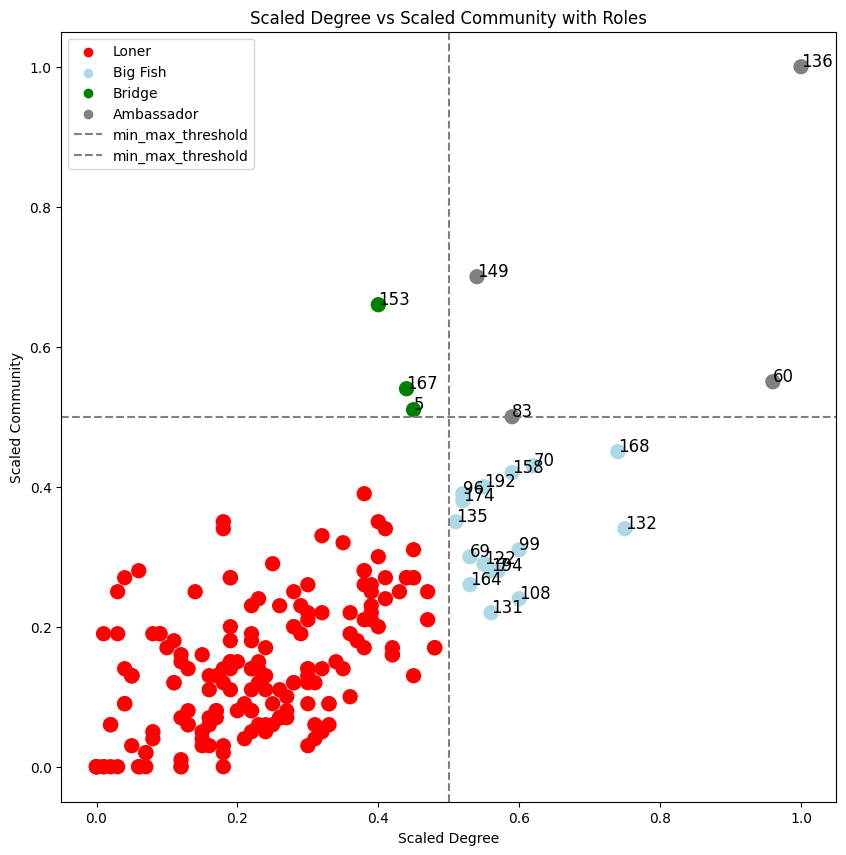

In [83]:
# Define the colors for the roles
colors = {'Loner': 'red', 'Big Fish': 'lightblue', 'Bridge': 'green', 'Ambassador': 'gray'}
# Assign the colors to the vertices based on column Role_min_max in the data frame and Column Vertex
node_colors = df.set_index('Vertex')['Role_min_max'].map(colors)

# Plot x = degree, y = community
plt.figure(figsize=(10, 10))
# Scatter plot of degree vs community with labels 
plt.scatter(df['Degree_scaled'], df['Community_scaled'], c=node_colors, s=100)
# Add labels for roles
for role, color in colors.items():
    plt.scatter([], [], color=color, label=role)
# Add labels for the vertices
for i, txt in enumerate(df['Vertex']):
    # Add labels for the vertices with role Big Fish, Bridge, Ambassador
    if df['Role_min_max'][i] == 'Big Fish' or df['Role_min_max'][i] == 'Bridge' or df['Role_min_max'][i] == 'Ambassador':
        plt.annotate(txt, (df['Degree_scaled'][i], df['Community_scaled'][i]), fontsize=12)

    else:# Dont add labels for the vertices with role Loner, because they are too many
        continue
    
plt.xlabel('Scaled Degree')
plt.ylabel('Scaled Community')
plt.title('Scaled Degree vs Scaled Community with Roles')
# Add max_min_threshold lines
plt.axvline(x=min_max_threshold, color='grey', linestyle='--', label='min_max_threshold')
plt.axhline(y=min_max_threshold, color='grey', linestyle='--', label='min_max_threshold')
# Add legend for Loners, Big Fish, Bridge, Ambassador and lines
plt.legend()
plt.show()


- **Loners:** With 175 musicians falling into this category, loners represent the majority of the network. These musicians have a low number of connections, showing that they are less active in collaborating with many different musicians.

- **Big Fish:** There are 16 musicians identified as big fish. They could be well-known musicians within a particular sub-genre or region who frequently collaborate with local peers but are less involved in the broader Jazz network.

- **Ambassadors:** Musician 136, 60, 132 are 70 are identified as ambassadors. These musicians are highly connected both within their community and across different parts of the network. They might be influential figures who work across various sub-genres, bringing together diverse groups of musicians and facilitating innovative collaborations.

- **Bridges:** Musician 153, 167 and 5 are identified as bridges. These musicians have fewer direct collaborations but are crucial in connecting different communities. These could be musicians who participate in multiple, distinct Jazz circles.

# Task 6 – Prediction
Using Random Forest Classifier and Support Vector Machine to predict future collaborations between Jazz musicians to suggest potential collaboration opportunities to artists and producers.

In [84]:
# Dataframe to store the results
df_results =  pd.DataFrame()

# Function evaluate the performance of a classifier
def add_results_to_df(df_results, model, y_train, y_test, y_train_pred, y_test_pred):
    '''
    Function to add the results of a model to a dataframe
    Args:
        df_results : DataFrame : a dataframe to store the results
        model : str : the name of the model
        dataset : str : the name of the dataset
        y_train : array : the true labels of the training set
        y_test : array : the true labels of the test set
        y_pred_train : array : the predicted labels of the training set
        y_pred_test : array : the predicted labels of the test set
    Returns:
        DataFrame : the dataframe with the added results
    '''
    for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
        df_results= pd.concat([df_results, pd.DataFrame([{
            "Model": model, 
            "Dataset": dataset,
            "Accuracy": ms.accuracy_score(actual, predicted),
            "Precision": precision_score(actual, predicted),
            "Recall": recall_score(actual, predicted),
            "F1_Score":f1_score(actual, predicted),
            "Confusion_Matrix": confusion_matrix(actual, predicted)
        }])], ignore_index=True)   
    return df_results

In [85]:
# Calculate the mean and standard deviation for each metric and model
def calculate_mean_std(df_results):
    """
    Calculate the mean and standard deviation for each metric and model.
    Args:
        df_results : DataFrame containing the results with columns 
                ['Model', 'Dataset', 'Precision', 'Recall', 'F1_Score', Confusion_Matrix']
    Returns:
        summary_df : DataFrame containing the mean and standard deviation for each metric and model
    """
    summary_df = df_results.groupby(['Model', 'Dataset']).agg(
        Accuracy_mean=('Accuracy', 'mean'),
        Accuracy_std=('Accuracy', 'std'),
        Precision_mean=('Precision', 'mean'),
        Precision_std=('Precision', 'std'),
        Recall_mean=('Recall', 'mean'),
        Recall_std=('Recall', 'std'),
        F1_Score_mean=('F1_Score', 'mean'),
        F1_Score_std=('F1_Score', 'std'),
        Confusion_Matrix_mean=('Confusion_Matrix', 'mean')
    ).reset_index()

    return summary_df

In [86]:
# Function to perform nested cross-validation for Node2Vec embeddings and a classifier
def nested_cv_node2vec_clf(df_results, G, model_name, node2vec_param_grid, mode_param_grid, outer_cv_folds=10, inner_cv_folds=5):
    '''
    Function to perform nested cross-validation for Node2Vec embeddings and a classifier.
    Args:
        G: NetworkX graph object
        model_name(str): the name of the model
        node2vec_param_grid(dict): a dictionary with the Node2Vec hyperparameters
        mode_param_grid(dict): a dictionary with the model hyperparameters
        outer_cv_folds(int): the number of outer cross-validation folds default=5
        inner_cv_folds(int): the number of inner cross-validation folds default=3
        df_results(DataFrame): a DataFrame to store the results 
    Returns:
        df_results: DataFrame with the results
        best_params_list: a list with the best parameters for the classifier
    '''
    # List to store the best parameters
    best_params_list = []

    # Outer CV
    for fold in range(outer_cv_folds): 
        # Use a different seed to get different splits within each fold
        dynamic_seed = fold

        # Create train and test subgraphs using EdgeSplitter
        edgeSplitter = EdgeSplitter(G) # Initialize EdgeSplitter
        # Select test set
        graph_without_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method='global', seed=dynamic_seed)

        # Initialize new EdgeSplitter without test set 
        edgeSplitter = EdgeSplitter(graph_without_test, G) 
        #Select train set
        graph_without_test_and_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method='global', seed=dynamic_seed)

        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=inner_cv_folds, shuffle=True, random_state=random_seed)
        
        best_inner_f1 = -1

        # Grid search for Node2Vec hyperparameters
        for node2vec_params in ParameterGrid(node2vec_param_grid):

            # Separate Node2Vec initialization parameters and fit parameters
            node2vec_init_params = {key: node2vec_params[key] for key in ['dimensions', 'walk_length', 'num_walks', 'p', 'q']}
            node2vec_fit_params = {key: node2vec_params[key] for key in ['window', 'min_count', 'batch_words']}
        
            # Initialize Node2Vec instance
            node2vec = Node2Vec(graph_without_test_and_train, **node2vec_init_params, workers=8, seed=random_seed, quiet=True)
            
            # Fit Node2Vec  
            model = node2vec.fit(**node2vec_fit_params) 
            edge_embeddings = HadamardEmbedder(keyed_vectors=model.wv)

            # Generate train and test edge embeddings
            train_embeddings = [edge_embeddings[str(x[0]), str(x[1])] for x in samples_train]
            test_embeddings = [edge_embeddings[str(x[0]), str(x[1])] for x in samples_test]

            # Distinguish between Random Forest and SVM
            if model_name == 'Random Forest':
                # Pipeline with StandardScaler and RandomForestClassifier
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=random_seed))
                ])
            elif model_name == 'Support Vector Machine':
                # Pipeline with StandardScaler and SVC
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', SVC(random_state=random_seed))
                ])
            elif model_name == 'Dummy Classifier': 
                # Dummy Classifier doesn't need scaling
                pipeline = Pipeline([
                    ('clf', DummyClassifier(random_state=random_seed))
                ])
            else:
                raise ValueError('Invalid model name. Please select either Random Forest, Support Vector Machine or Dummy Classifier.')

            # Fit model with pipeline
            pipeline.fit(train_embeddings, labels_train)

            # Predict using best Random Forest model
            pred_test = pipeline.predict(test_embeddings)

            # Calculate f1 score 
            test_f1 = f1_score(labels_test, pred_test)

            if test_f1 > best_inner_f1:
                best_inner_f1 = test_f1
                best_node2vec_init_params = node2vec_init_params
                best_node2vec_fit_params = node2vec_fit_params

        # Train final model with best parameters from inner CV
        node2vec = Node2Vec(graph_without_test_and_train, **best_node2vec_init_params, workers=8, seed=random_seed, quiet=True)
        model = node2vec.fit(**best_node2vec_fit_params)
        edge_embeddings = HadamardEmbedder(keyed_vectors=model.wv)
        
        # Generate train and test edge embeddings
        train_embeddings = [edge_embeddings[str(x[0]), str(x[1])] for x in samples_train]
        test_embeddings = [edge_embeddings[str(x[0]), str(x[1])] for x in samples_test]

        if model_name == 'Random Forest':
            # Initialize Pipline with Standard Scaler and Random Forest Classifier 
            pipeline = Pipeline([
                ('scaler', StandardScaler()), # Scale, even if it's not necessary for Random Forest
                ('clf', RandomForestClassifier(random_state=dynamic_seed))
            ])
        elif model_name == 'SVM':
            # Initialize Pipline with Standard Scaler and Support Vector Machine Classifier
            pipeline = Pipeline([
                ('scaler', StandardScaler()),# Scale
                ('clf', SVC(random_state=random_seed))
            ])
        elif model_name == 'Dummy Classifier':
            # Initialize Pipline with Dummy Classifier (no need to scale)
                pipeline = Pipeline([
                ('clf', DummyClassifier(random_state=random_seed))
            ])

        # Grid search for Model hyperparameters 
        grid_search = GridSearchCV(pipeline, mode_param_grid, cv=inner_cv, scoring='f1', n_jobs=-1)
        grid_search.fit(train_embeddings, labels_train)

        # Get best classifier and parameters
        best_clf = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Predict on the train and test set
        pred_train = best_clf.predict(train_embeddings)
        pred_test = best_clf.predict(test_embeddings)

        # Store best parameters
        best_params_list.append(best_params)

        # Calculate metrics
        df_results = add_results_to_df(df_results, 
                                       model_name, 
                                       labels_train, labels_test,
                                        pred_train, 
                                        pred_test)
        
    # Find the best parameters by taking the mode (most common value)
    best_params_df = pd.DataFrame(best_params_list)
    best_params = best_params_df.mode().iloc[0].to_dict()

    return df_results, best_params

In [87]:
# Define parameter grids for Node2Vec (using default values) to save computation time
node2vec_param_grid = {
    'dimensions': [128],
    'walk_length': [80],
    'num_walks': [10],
    'p': [1],
    'q': [1],
    'window': [10],
    'min_count': [1],
    'batch_words': [4]
}

#### **Baseline (Dummy Classifier)**

In [88]:
# Define parameter grids for Dummy Classifier
dummy_param_grid = {
    'clf__strategy': ['uniform', 'most_frequent', 'stratified']
}

# Do nested cross-validation for Node2Vec and SVM
df_results, _ = nested_cv_node2vec_clf(df_results, G, 'Dummy Classifier',node2vec_param_grid ,dummy_param_grid)

** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246

#### **Random Forest Classifier**

In [89]:
# Define parameter grids for Random Forest
rf_param_grid = {
    'clf__n_estimators': [10, 50, 70, 80],
    'clf__max_depth': [None, 3, 5, 8, 10, 15],
    'clf__min_samples_split': [2, 3, 4, 5],
    'clf__min_samples_leaf': [2, 3, 4 , 5]
}

# Do nested cross-validation for Node2Vec and Random Forest
df_results, best_params_rf  = nested_cv_node2vec_clf(df_results, G,'Random Forest' ,node2vec_param_grid ,rf_param_grid)

** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246

#### **Support Vector Machine Classifier**

In [90]:
# Define parameter grids for SVM
svm_param_grid = {
    'clf__C': [0.01, 0.1, 0.5, 1, 5, 10], 
    'clf__gamma': [0.01, 0.1, 0.5, 1, 5],
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Do nested cross-validation for Node2Vec and SVM
df_results, best_params_smv = nested_cv_node2vec_clf(df_results, G, 'Support Vector Machine', node2vec_param_grid ,svm_param_grid)

** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246 negative edges. **
** Sampled 274 positive and 274 negative edges. **
** Sampled 246 positive and 246

#### **Evaluate the performance of the models**

In [91]:
# Summary of the results
df_summary = calculate_mean_std(df_results).round(2)

# Don't show the confusion matrix in the summary
df_summary_filtered = df_summary[['Model', 'Dataset','Accuracy_mean', 'Accuracy_std', 'Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'F1_Score_mean', 'F1_Score_std']]

In [92]:
# Display Summary of Test results
display(df_summary_filtered[df_summary_filtered['Dataset'] == 'test'].sort_values('Accuracy_mean', ascending=False))

# Display Summary of Train results 
display(df_summary_filtered[df_summary_filtered['Dataset'] == 'train'].sort_values('Accuracy_mean', ascending=False))

,Model,Dataset,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_Score_mean,F1_Score_std
4,Support Vector Machine,test,0.84,0.02,0.84,0.02,0.84,0.02,0.84,0.02
2,Random Forest,test,0.83,0.02,0.82,0.02,0.85,0.03,0.84,0.02
0,Dummy Classifier,test,0.51,0.00,0.51,0.00,0.48,0.00,0.50,0.00


,Model,Dataset,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_Score_mean,F1_Score_std
3,Random Forest,train,0.99,0.01,0.99,0.01,1.00,0.01,0.99,0.01
5,Support Vector Machine,train,0.97,0.03,0.96,0.03,0.98,0.03,0.97,0.03
1,Dummy Classifier,train,0.52,0.00,0.52,0.00,0.50,0.00,0.51,0.00


#### **Findings:**

- The **Dummy Classifier** serves as a baseline model and performs poorly, as expected. The precision, recall, and F1-score are close to random guessing, with values around 0.5.

-  The **Random Forest** model shows excellent performance on the training set, indicating that it fits the training data very well. However, the drop in performance on the test set suggests overfitting. The low test set variance suggests stable generalization performance. The accuracy is consistent with precision, recall, and F1-score, all indicating strong performance but with overfitting concerns.

- The **SVM** model also shows strong performance, with slightly better generalization than Random Forest as indicated by the test set metrics. The train-test performance gap is smaller than that of Random Forest, suggesting less overfitting.


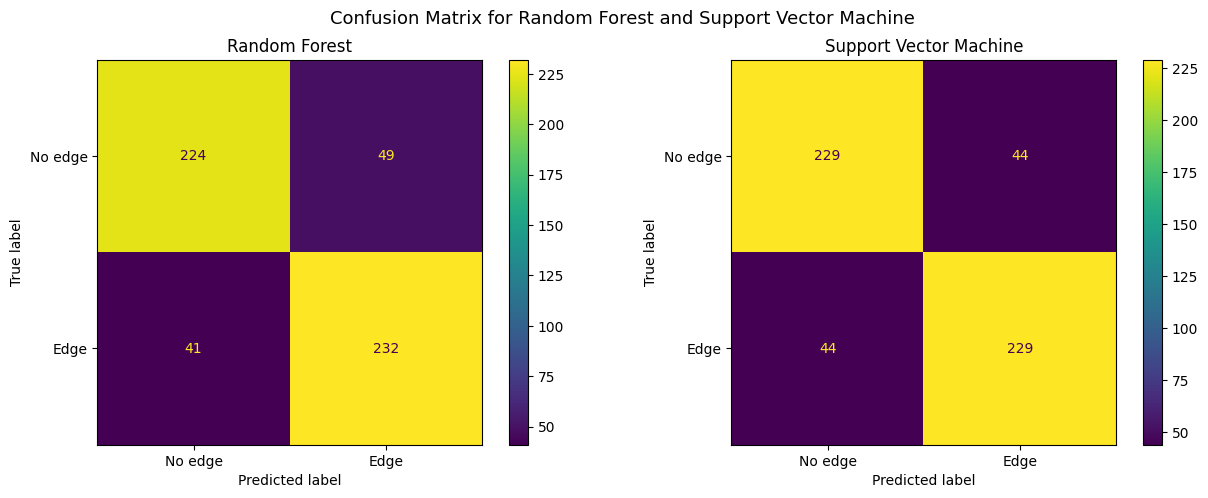

In [93]:
# Look at the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for ax, model in zip(ax, ['Random Forest', 'Support Vector Machine']):
    
    # Get the confusion matrix
    conf_matrix = df_summary.loc[(df_summary['Model'] == model) & (df_summary['Dataset'] == 'test'), 'Confusion_Matrix_mean'].values[0]
    conf_matrix = conf_matrix.astype(int) # Cast to integer

    # Plot the confusion matrix
    ms.ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
    ax.set_title(model)
    ax.set_xticklabels(['No edge', 'Edge'])
    ax.set_yticklabels(['No edge', 'Edge'])

fig.suptitle('Confusion Matrix for Random Forest and Support Vector Machine' , fontsize=13)
plt.show()

- The **Random Forest** model correctly identifies a high number of true positives and true negatives, indicating strong performance. The relatively low number of incorrectly predicted collaborations (52) and collaborations missed (41) suggests that the model has good precision and recall. The balance between true negatives, true positives, false positives, and false negatives reflects the model's capability to correctly predict both the presence and absence of collaborations among Jazz musicians.

- The **SVM** model performs very similarly to the Random Forest model. It has slightly higher true negatives (225) and slightly lower incorrectly predicted collaborations (48) compared to Random Forest. The number of missed collaborations (41) and correctly predicted collaborations (232) are identical to the Random Forest model.

#### **Model Selection:**

Both models show high true positive and true negative rates, with low numbers of missed collaborations and incorrectly predicted collaborations. The SVM model slightly outperforms the Random Forest model in terms of correctly identifying non-collaborations (true negatives) and reducing incorrectly predicted collaborations. 
Therefore, the **SVM model will be selected** for predicting future collaborations between Jazz musicians.

# Task 7 – Conclusions and Future Work

#### **1. Summarize and Interpret the Achieved Results**

The analysis of the Jazz musicians collaboration network yielded significant insights and successful predictions of potential future collaborations:

- **Graph Properties:** The Jazz network, with 198 musicians and 2742 collaborations, exhibits a small-world property, with tightly knit communities as indicated by high clustering coefficients and transitivity.

- **Central Nodes:** Musicians 136 and 60 are key influencers, showing the highest centralities, while musicians 132 and 70 are well-connected but less central in bridging communities. Musician 149 serves as a crucial link between different communities despite having fewer collaborations.

- **Community-Based Roles:** The network mainly consists of "Loners" (175 musicians). Sixteen are "Big Fishs," four (136, 60, 132, 70) are "Ambassadors," and three (153, 167, 5) are "Bridges," acting as cross-community connections.

- **Prediction Task:** The SVM model outperformed the Random Forest model in predicting future collaborations, showing higher accuracy and generalization capabilities.

#### **2. Compare Results to Expected Outcomes**

The results align with the project goals of BlueNote Records, leveraging data science to identify and enable promising jazz collaborations:

- **IDA:** The analysis provided a comprehensive understanding of the network, revealing tightly knit communities and influential musicians.
- **Graph Properties:** Highlighted the network's small-world nature, crucial to promoting rapid and diverse collaboration.
- **Central Nodes:** Identifying key influencers supports targeted strategies for impactful collaborations.
- **Prediction Task:** Successful prediction using the SVM model aligns with the approach to suggest collaboration opportunities.

These outcomes support BlueNote Records in enabling strategic collaborations, enhancing the music library, and maintaining industry leadership.

#### **3. Explain the Generated Value**

The analysis and prediction algorithms provide significant value to BlueNote Records by:

- **Gaining Network Insights:** Understanding network properties like clustering coefficients and path lengths to enhance connectivity and collaboration strategies.

- **Identifying Key Musicians:** Pinpointing influential musicians with high centrality measures to promote cross-genre collaborations.

- **Understanding Community-Based Roles:** Gaining insights into different roles within the network, to strategically engage musicians.

- **Enabling Strategic Collaborations:** Possibility to identifying potential collaboration opportunities to suggest projects to artists.

#### **4. Recommend a Course of Action**

Based on the results, BlueNote Records should:

- **Adopt the SVM Model:** Utilize the SVM model to predict and recommend potential collaborations, providing data-driven insights to guide collaboration decisions.
- **Focus on Central Musicians:** Leverage the influence of key musicians (136, 60, 132, 70) to bridge different communities and promote cross-genre collaborations.
- **Support Loners:** Encourage less connected musicians to engage in more collaborations, supporting network growth and diversity.
- **Support Ambassadors and Bridges:** Encourage musicians identified as Ambassadors and Bridges to participate in diverse projects, enhancing network connectivity.

These actions will help BlueNote Records strategically promote collaborations, potentially leading to innovative projects that enrich the label's portfolio and maintain its industry leadership.

#### **5. Reflect on Limitations and Possible Pitfalls**

- **Overfitting:** The Random Forest and SVM model bouth showed signs of overfitting, indicating the need for careful parameter tuning and validation.
- **Graph Dynamics:** The analysis is based on a static snapshot of the network. Musicians collaborations can evolve over time, potentially affecting prediction accuracy.
- **Data Quality:** The dataset is from 2003 and may not reflect current collaboration patterns. Updated data would improve the model's relevance.
- **Lack of Success Metrics:** The network contains no information about the success or impact of collaborations. Incorporating such metrics could enhance the understanding of the Jazz network and prediction of successful collaborations. 

#### **6. Critically Discuss the Employed Methodology**

The chosen methodology was effective, but some improvements could be made:

- **Dynamic Network Analysis:** Incorporate temporal aspects to reflect the evolving nature of the collaboration.
- **Feature Engineering:** Integrate more features, such as  musician attributes or success metrics, to provide deeper insights and improve model performance.
- **Node2Vec Optimization:** Fine-tune the Node2Vec embeddings to capture more relationships between musicians and enhance prediction capabilities.

#### **7. Propose Ideas for Future Work**

- **Update the Dataset:** Use more recent data to reflect the current state of the Jazz musicians collaboration network, ensuring that the predictions are relevant to today's industry dynamics.
- **Dynamic Network Analysis:** Investigate how the network evolves over time. Understanding the formation and resolution of collaborations could provide deeper insights into the factors influencing successful partnerships.
- **Extended Features:** Acquire additional features such as success metrics and musician attributes. This could refine predictions and offer a better understanding of collaboration dynamics.
- **Interactive Tools:** Develop interactive visualization tools for musicians and producers. These tools can help explore potential collaborations easily and make data-driven decisions about new projects.
- **Community Detection:** Utilize clustering algorithms like Louvain or Girvan-Newman to identify and analyze community structures within the network. Using these insights can enhance strategies for promoting collaborations within and across communities.